In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np

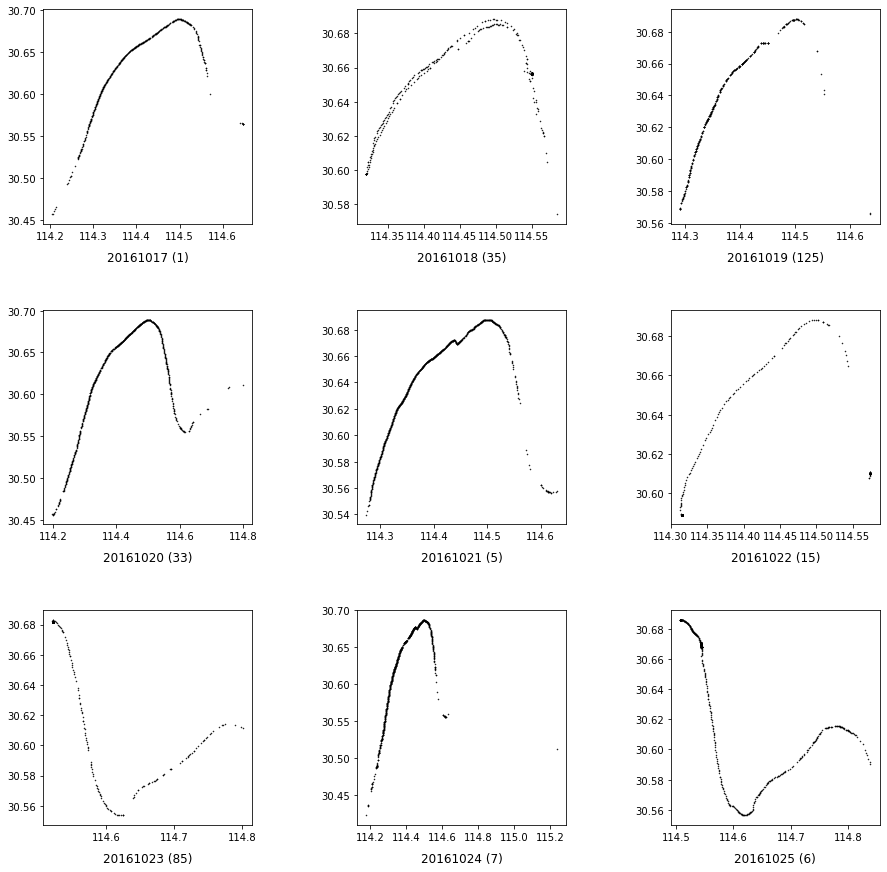

In [2]:
path="D:\\数模选拔\\data\\"
import matplotlib.ticker as ticker

filenameset=[
    "20161017 (1)",
    "20161018 (35)",
    "20161019 (125)",
    "20161020 (33)",
    "20161021 (5)",
    "20161022 (15)",
    "20161023 (85)",
    "20161024 (7)",
    "20161025 (6)"]
i=1
plt.figure(figsize=(15,15))
plt.title("选取的9个图片的初始数据")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)

for item in filenameset:
    P=path+item+".txt"
    data=pd.read_csv(P,sep='\\s+',header=None)
    data.drop(data.columns[9],axis=1)
    #读取数据
    date=data.loc[:,0]
    time=data.loc[:,1]
    id=data.loc[:,2]
    lon_now=data.loc[:,3]
    lat_now=data.loc[:,4]
    lon_pre=data.loc[:,5]
    lat_pre=data.loc[:,6]
    v=data.loc[:,7]
    angle=data.loc[:,8]
    #第9列不要了
    #画出距离图
    ax=plt.subplot(3,3,i)
    ax.scatter(lon_now,lat_now,1,color='black',marker='.')
    plt.title(item,y=-0.2)
    i+=1

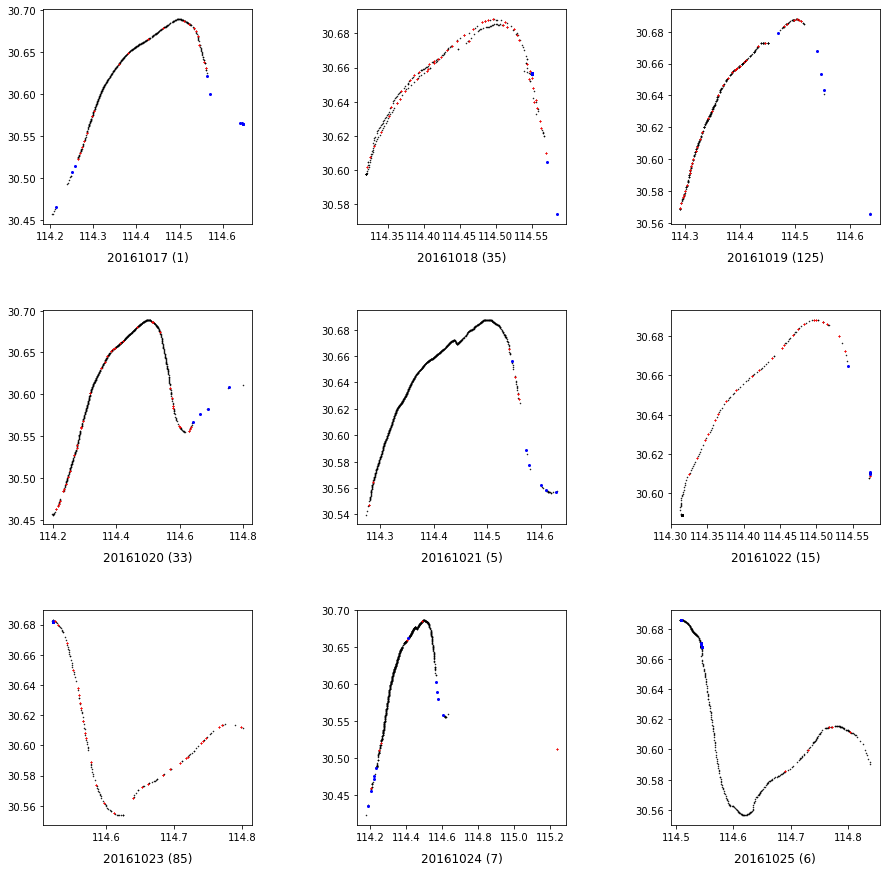

In [3]:
import math
from global_land_mask import globe
from datetime import datetime
cnt=1
plt.figure(figsize=(15,15))
plt.title("选取的9个图片的噪声和丢失数据")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)

for item in filenameset:
    P=path+item+".txt"
    data=pd.read_csv(P,sep='\\s+',header=None)
    data.drop(data.columns[9],axis=1)
    #读取数据
    date=data.loc[:,0]
    time=data.loc[:,1]
    id=data.loc[:,2]
    lon_now=data.loc[:,3]
    lat_now=data.loc[:,4]
    lon_pre=data.loc[:,5]
    lat_pre=data.loc[:,6]
    v=data.loc[:,7]
    angle=data.loc[:,8]
    cosa=angle.map(lambda x:math.cos(x))
    sina=angle.map(lambda x:math.cos(x))
    dlon=lon_now-lon_pre
    dlat=lat_now-lat_pre
    t=[]
    for i,j in zip(date,time):
        t.append(datetime.strptime(i+" " +j ,"%Y-%m-%d %H:%M:%S"))
    l=len(data)
    #判断nosie，用红色标记
    l=len(data)
    flag=np.array(time)
    for i in range(1,l-1):
        flag[i]=0
        if lon_now[i]<114.01 or lon_now[i]>115.5 or lat_now[i]<29.8 or lat_now[i]>31.33:
            flag[i]=1
            continue
        if ~globe.is_land(lat_now[i],lon_now[i]):
            flag[i]=1
            continue
        dtime=(t[i+1]-t[i]).total_seconds()
        if dtime<360:
            xmax=dtime*0.51444*20   #转换为m
            if (xmax/111000)**2<(dlon[i]**2+dlat[i]**2):
                flag[i]=1
                continue
            #if dtime<100:
            #    actual_angle=math.atan(dlat[i]/dlon[i])
            #    if math.abs(actual_angle-angle[i])<angle[i]:
            #        flag[i]=1
            #        continue
        else : #判定为数据丢失
            flag[i]=2
    ax=plt.subplot(3,3,cnt)
    ax.scatter(lon_now,lat_now,1,color='black',marker='.')
    
    for i in range(1,l):
        if flag[i]==1:

            ax.scatter(lon_now[i],lat_now[i],1,color='red',marker='x')
            data.drop([i])
        if flag[i]==2:
            ax.scatter(lon_now[i],lat_now[i],4,color='blue',marker='o')
            
    plt.title(item,y=-0.2)
    cnt+=1


0.0
2.6505726415425997e-27


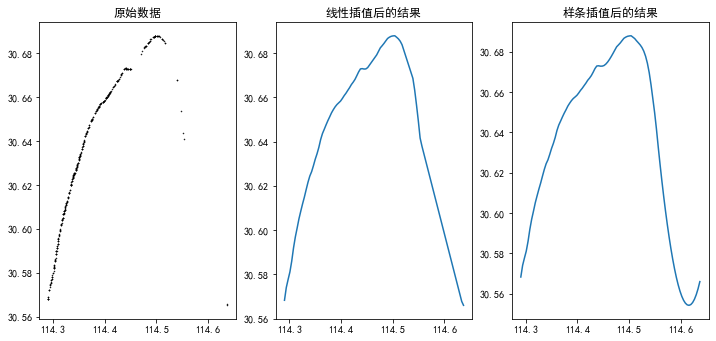

In [4]:
#插值算法
#受到篇幅限制，只选用上图中20161019（125）
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from scipy import interpolate as si
path1=path+"20161019 (125).txt"
data=pd.read_csv(path1,sep='\\s+',header=None)
date=data.loc[:,0]
time=data.loc[:,1]
id=data.loc[:,2]
lon_now=data.loc[:,3]
lat_now=data.loc[:,4]
min_lon=lon_now.min()
max_lon=lon_now.max()
lons=np.linspace(min_lon,max_lon,100)
linear = si.interp1d(lon_now, lat_now, kind="linear")
lats=linear(lons)
plt.figure(figsize=(12,12))
plt.subplot(2,3,1)
plt.scatter(lon_now,lat_now,1,color='black',marker='.')
plt.title("原始数据")
plt.subplot(2,3,2)
plt.plot(lons,lats)
plt.title("线性插值后的结果")
l1=lon_now.drop_duplicates(keep='first',inplace=False)
l2=lat_now.drop_duplicates(keep='first',inplace=False)
func1 = si.interp1d(l1, l2, kind="cubic")
lats2=func1(lons)
plt.subplot(2,3,3)
plt.plot(lons,lats2)
plt.title("样条插值后的结果")
r1=np.dot(lat_now-linear(lon_now),lat_now-linear(lon_now))
print(r1)
r2=np.dot(lat_now-func1(lon_now),lat_now-func1(lon_now))
print(r2)


In [5]:
# 验证插值的效果
# 采用交叉验证的方法
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(lon_now,lat_now,test_size = 0.15,random_state =4)
linear = si.interp1d(x_train, y_train, kind="linear")
y_p=linear(x_test)
l1=x_train.drop_duplicates(keep='first',inplace=False)
l2=y_train.drop_duplicates(keep='first',inplace=False)
func1 = si.interp1d(l1, l2, kind="cubic")
y2_p=func1(x_test)
r1=np.dot(y_p-y_test,y_p-y_test)
print(r1)
r2=np.dot(y2_p-y_test,y2_p-y_test)
print(r2)

4.630074141970811e-08
1.215129706410325e-08


In [16]:
import math

def Rad(d):
    return d * math.pi / 180

def Geodist(point1,point2):
    radLat1 = Rad(point1[1])
    radLat2 = Rad(point2[1])
    delta_lon = Rad(point1[0] - point2[0])
    top_1 = math.cos(radLat2) * math.sin(delta_lon)
    top_2 = math.cos(radLat1) * math.sin(radLat2) - math.sin(radLat1) * math.cos(radLat2) * math.cos(delta_lon)
    top = math.sqrt(top_1 * top_1 + top_2 * top_2)
    bottom = math.sin(radLat1) * math.sin(radLat2) + math.cos(radLat1) * math.cos(radLat2) * math.cos(delta_lon)
    delta_sigma = math.atan2(top, bottom)
    distance = delta_sigma * 6378137.0

    return round(distance,3)


#2.点弦距离
def get_vertical_dist(pointA,pointB,pointX):
    a=math.fabs(Geodist(pointA,pointB))

    #当弦两端重合时,点到弦的距离变为点间距离
    if a==0:
        return math.fabs(Geodist(pointA,pointX))

    b=math.fabs(Geodist(pointA,pointX))
    c=math.fabs(Geodist(pointB,pointX))
    p=(a+b+c)/2
    S=math.sqrt(math.fabs(p*(p-a)*(p-b)*(p-c)))

    vertical_dist=S*2/a

    return vertical_dist






#3.递归压缩
def DP_compress(point_list,output_point_list,Dmax):
    start_index=0
    end_index=len(point_list)-1

    #起止点必定是关键点,但是作为递归程序此步引入了冗余数据,后期必须去除
    output_point_list.append(point_list[start_index])
    output_point_list.append(point_list[end_index])

    if start_index<end_index:
        index=start_index+1        #工作指针,遍历除起止点外的所有点
        max_vertical_dist=0        #路径中离弦最远的距离
        key_point_index=0        #路径中离弦最远的点,即划分点

        while(index<end_index):
            cur_vertical_dist=get_vertical_dist(point_list[start_index],point_list[end_index],point_list[index])
            if cur_vertical_dist>max_vertical_dist:
                max_vertical_dist=cur_vertical_dist
                key_point_index=index        #记录划分点
            index+=1

        #递归划分路径
        if max_vertical_dist>=Dmax:
            DP_compress(point_list[start_index:key_point_index],output_point_list,Dmax)
            DP_compress(point_list[key_point_index:end_index],output_point_list,Dmax)

#4.平均误差
def get_MeanErr(point_list,output_point_list):
    Err=0

    start_index=0
    end_index=len(output_point_list)-1

    while(start_index<end_index):        #遍历所有关键点
        #选取两相邻关键点
        pointA_id=int(output_point_list[start_index][2])
        pointB_id=int(output_point_list[start_index+1][2])

        id=pointA_id+1        #工作指针,用于遍历非关键点
        while(id<pointB_id):        #遍历两关键点之间的非关键点
            Err+=get_vertical_dist(output_point_list[start_index],output_point_list[start_index+1],point_list[id])
            id+=1

        start_index+=1

    return Err/len(point_list)



#5.主程序
point_list=[]
output_point_list=[]

#将处理后的数据读入内存
#fd=open(r"20161019 (125).txt",'r')
i=0
path="D:\\数模选拔\\data\\"
for f  in filenameset:
    path1=path+f+".txt"
    data=pd.read_csv(path1,sep='\\s+',header=None)
    lon_now=data.loc[:,3]
    lat_now=data.loc[:,4]
    for i in range(len(data)):
        longitude=lon_now[i]
        latitude=lat_now[i]
        point_list.append((longitude,latitude,i))


    DP_compress(point_list,output_point_list,Dmax=80)
    output_point_list=list(set(output_point_list))        #去除递归引入的冗余数据
    output_point_list=sorted(output_point_list,key=lambda x:x[2])        #按照id排序

    #将压缩数据写入输出文件
    fd=open(r".\output.txt",'w')
    for point in output_point_list:
        fd.write("{},{},{}\n".format(point[2],point[0],point[1]))
    fd.close()
    print(f)
    print("compression rate={}/{}={}".format(len(output_point_list),len(point_list),len(output_point_list)/len(point_list)))
    print("mean error:{}".format(get_MeanErr(point_list,output_point_list)))

[(114.205147, 30.45637, 0), (114.646307, 30.564287, 395), (114.205147, 30.45637, 0), (114.487573, 30.687677, 304), (114.205147, 30.45637, 0), (114.329587, 30.613967, 136), (114.205147, 30.45637, 0), (114.250973, 30.506893, 11), (114.205147, 30.45637, 0), (114.214507, 30.46545, 4), (114.239413, 30.492303, 5), (114.247107, 30.502273, 10), (114.25712, 30.51421, 12), (114.328973, 30.61344, 135), (114.25712, 30.51421, 12), (114.308587, 30.590177, 94), (114.25712, 30.51421, 12), (114.275853, 30.539283, 32), (114.276267, 30.539883, 33), (114.308213, 30.589633, 93), (114.276267, 30.539883, 33), (114.28572, 30.555797, 46), (114.28732, 30.558713, 47), (114.307773, 30.589047, 92), (114.309, 30.590807, 95), (114.328427, 30.612993, 134), (114.309, 30.590807, 95), (114.318493, 30.603007, 116), (114.318947, 30.60354, 117), (114.32732, 30.61205, 133), (114.330707, 30.614927, 137), (114.486747, 30.687453, 303), (114.330707, 30.614927, 137), (114.38216, 30.649743, 201), (114.330707, 30.614927, 137), (11

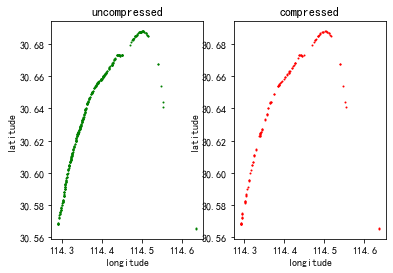

In [7]:
#6.可视化
####point_list
import matplotlib.pyplot as plt
path1=path+"20161019 (125).txt"
data=pd.read_csv(path1,sep='\\s+',header=None)
lon_now=data.loc[:,3]
lat_now=data.loc[:,4]
point_list=[]
output_point_list=[]

for i in range(len(data)):
    longitude=lon_now[i]
    latitude=lat_now[i]
    point_list.append((longitude,latitude,i))

DP_compress(point_list,output_point_list,Dmax=10)
output_point_list=list(set(output_point_list))        #去除递归引入的冗余数据
output_point_list=sorted(output_point_list,key=lambda x:x[2])        #按照id排序
uncompressed=[[],[]]
for point in point_list[:]:#point_list
    uncompressed[0].append(point[0])
    uncompressed[1].append(point[1])
plt.subplot(1,2,1)
plt.scatter(uncompressed[0],uncompressed[1],s=1,color="green")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("uncompressed")
compressed=[[],[]]
for point in output_point_list:#output_point_list
    compressed[0].append(point[0])
    compressed[1].append(point[1])
plt.subplot(1,2,2)
plt.scatter(compressed[0],compressed[1],s=1,color='r')
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("compressed")
plt.show()